# Subjective Verbs

This notebook seeks to merge ideas in the 2 SV pair notebooks.

## How do we relate back to `I`?

<div class="alert alert-block alert-info"> 
    <p>A note about the naming of variables below:</p>
    <ul>
        <li><code>m</code> and <code>w</code> represent the subcorpus, men or women speakers</li>
        <li><code>pp</code> stands for personal pronouns, usually "he," "she," and "I" here.
        <li><code>svo</code> signifies that the complete SVO-triplet is used</li>
        <li><code>sv</code> signifies that just the subject-verb pairs are being used</li>
    </ul>   
</div>

What we want to explore is both the usual ways that speakers (men or women) pair the pronouns *he*, *she*, *i* with verbs and also, perhaps, the significant pairings. The usual way can be approached via **counts**, which we have visualized in a separate notebook with Sankey plots.

Relative frequencies would let us compare across the two subcorpora ... or would this be approached better by some form of TF-IDF? (And would we need to determine some sort of lower threshold of the number of sentences in which a verb must occur? We're not interested in verb only used in a single sentence but verbs used often in a pairing in one subcorpus and not in the other.)

In [1]:
# IMPORTS
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# LOAD DATAFRAMES
# the `lem` suffix indicates the verbs have been lemmatized
svos_m = pd.read_csv("../output/svos_m_lem.csv", index_col=0)
svos_w = pd.read_csv("../output/svos_w_lem.csv", index_col=0)

# Save the SVO count for each corpus for calculating relative frequencies
m_svo_count = svos_m.shape[0]
w_svo_count = svos_w.shape[0]

# Output something to check our efforts
print(m_svo_count, w_svo_count)

80460 26610


In [2]:
svos_m

,subject,verb,object
0,i,blow,[conference]
1,i,want,"[to, thank, all, of, you, for, the, many, nice..."
2,i,need,[that]
3,laughter,put,[yourselves]
4,i,fly,[two]
...,...,...,...
80455,you,imagine,[him]
80456,you,see,"[credit, rating]"
80457,we,do,[what]
80458,it,expose,[humanity]


## SV Pairs with "She", "He", and "I"

In [3]:
# Create a list of the pronouns we want to see
pronouns = ["he", "she", "i"]

# Function to retrive the count the number of times subjects,
# here a list of pronouns, are paired with verbs
def svPairs (df, pplist):    
    temp = df[df["subject"].isin(
        pplist)].value_counts(
        subset=['subject', 'verb']).reset_index()
    # Re-label the new column from "0" to something human-readable
    temp.rename(columns={0:'v_freq'}, inplace=True)
    # Add a column with relative frequency
    temp['v_rfreq'] = temp['v_freq'] / df.shape[0]
    return temp

In [4]:
m_pp_v = svPairs(svos_m, pronouns)
w_pp_v = svPairs(svos_w, pronouns)

print(m_pp_v.shape)
print(w_pp_v.shape)

# m_pp_v.to_csv("../output/m_pp_v.csv")
# w_pp_v.to_csv("../output/w_pp_v.csv")

(1723, 4)
(1069, 4)


In [5]:
m_pp_v.head()

,subject,verb,v_freq,v_rfreq
0,i,have,1318,0.016381
1,i,want,1210,0.015039
2,i,go,1076,0.013373
3,i,do,650,0.008079
4,i,get,586,0.007283


## Subjects as Verb Features

In the cells below, we … 

1. **create 6 distinct dataframes**, one each for men and women speakers and the three pronouns.
2. **transpose each "subjective" dataframe** into a single row with the verbs associated with as columns and their relative frequencies as values.
3. **stack those rows** to get a unified dataframe with all 6 subject positions and verbs associated with them.
4. **transpose unified dataframe** to have the features as rows and the speaker-pronoun documents as columns (so we can do some math on the features). I.e., `verbs` dataframe below.

In [6]:
# function to filter SVOs for 
def filterdrop (df, pronoun, threshold):
    dftemp = df.loc[(df['subject'] == pronoun)]
    dftemp = dftemp.drop(columns=['subject', 'v_rfreq'])
    dftemp = dftemp[dftemp.v_freq > threshold]
    return dftemp

In [7]:
# Establish the minimum number of instances a verb occurs
# for us to consider it
verb_min = 2

# Create our pronoun-verb dataframes for he, she, i
m_he = filterdrop(m_pp_v, "he", verb_min)
w_he = filterdrop(w_pp_v, "he", verb_min)

m_she = filterdrop(m_pp_v, "she", verb_min)
w_she = filterdrop(w_pp_v, "she", verb_min)

m_i = filterdrop(m_pp_v, "i", verb_min)
w_i = filterdrop(w_pp_v, "i", verb_min)

# Print counts & preview a dataframe
print(f"m_he:  {m_he.shape[0]}, w_he:  {w_he.shape[0]}")
print(f"m_she: {m_she.shape[0]}, w_she: {w_she.shape[0]}")
print(f"m_i:   {m_i.shape[0]}, w_i:   {w_i.shape[0]}")
print("\n w_i looks like:")
print(w_i.head())

m_he:  141, w_he:  56
m_she: 58, w_she: 55
m_i:   380, w_i:   213

 w_i looks like:
   verb  v_freq
0  have     586
1  want     424
2    go     330
3    do     226
4   get     203


In [8]:
# This function takes the two columns of verb and count,
# transposes them, into a dataframe of a single row,
# with the verb as the column name
def makestackable (df, indexname):
    df_T = df.transpose()
    df_T.columns = df_T.iloc[0]
    df_T.drop(index=df_T.index[0], axis=0, inplace=True)
    df_T.index = [indexname]
    return df_T

# We use the function to create 6 dataframes
m_it = makestackable(m_i, "m_i")
w_it = makestackable(w_i, "w_i")
m_het = makestackable(m_he, "m_he")
w_het = makestackable(w_he, "w_he")
m_shet = makestackable(m_she, "m_she")
w_shet = makestackable(w_she, "w_she")

# ... that we then "stack" together 
# with the verbs as columns and the counts as values
concatenated = pd.concat([w_it, m_it, w_het, m_het, w_shet, m_shet])
concatenated.fillna(0, inplace=True)

# List of verbs
verb_list = list(concatenated.columns)

# View the results
concatenated.head(6)

verb,have,want,go,do,get,tell,like,know,start,love,...,fund,postulate,appeal,escape,suffer,sue,spin,brush,feed,lower
w_i,586,424,330,226,203,169,160,154,145,137,...,0,0,0,0,0,0,0,0,0,0
m_i,1318,1210,1076,650,586,326,462,274,377,271,...,0,0,0,0,0,0,0,0,0,0
w_he,80,20,32,29,19,16,7,4,12,4,...,0,0,0,0,0,0,0,0,0,0
m_he,232,71,78,111,90,58,14,27,42,5,...,3,3,3,3,3,3,3,0,0,0
w_she,63,11,22,33,20,18,6,6,9,10,...,0,0,0,0,0,0,0,3,3,0
m_she,94,32,34,41,24,20,5,10,17,4,...,0,0,0,0,0,0,0,0,0,3


In [9]:
# Having done the work above, we now rotate the dataframe again
# in order to have the speaker-pronouns as columns and the verbs as rows
verbs = concatenated.transpose()
print(verbs.shape)
print(verbs.head())

(415, 6)
      w_i   m_i  w_he  m_he  w_she  m_she
verb                                     
have  586  1318    80   232     63     94
want  424  1210    20    71     11     32
go    330  1076    32    78     22     34
do    226   650    29   111     33     41
get   203   586    19    90     20     24


> ***He/She Variant***: The cell below creates a dataframe with only the 2 x 2 speaker gender and subject gender and names it the same as the 2 x 3 dataframe, which includes the *I*, above. Please make sure you know which one you want to see.

In [10]:
heshe = pd.concat([m_het, w_het, m_shet, w_shet])
heshe.fillna(0, inplace=True)

# List of verbs
verb_list = list(heshe.columns)

# The transpose
verbs = heshe.transpose()
print(verbs.shape)
print(verbs.head())

(160, 4)
      m_he  w_he  m_she  w_she
verb                          
have   232    80     94     63
say    132    39     47     31
do     111    29     41     33
get     90    19     24     20
go      78    32     34     22


### The TF-IDF Part

We are going to treat each of the speaker-pronoun columns as a document, so that we can explore which verbs are evenly distributed across the pairings and which differentiate the actions available to a subject.

#### With Relative Frequency of Terms within Pseudo-Documents

In [11]:
# We need totals both by term (rows) and by document (columns)
# A peculiarity of pandas means we need to get rows first, then columns

# Totals per verb:
verbs["total"] = verbs.sum(axis = 1)

# Totals per document
doc_totals = verbs.sum(axis = 0)

# To hold our totals
new_verbs = verbs.copy()

# View the total number of s-v pairs per pronoun
doc_totals

# Get TF by "document"
verbs_rel = verbs/doc_totals

# A quick visual check COMMENTED OUT
# verbs_rel.head(10).style.background_gradient(axis=None, cmap='icefire')

# Reclaim our totals:
verbs_rel["total"] = new_verbs["total"]
verbs_rel.head()

# establish that we only want to work on the counts
# for each pronoun and not the total
cols = verbs_rel.columns
cols = list(cols)[:-1]


# the TFIDF part
for col in cols:
    verbs_rel[col] = (1/new_verbs["total"])*verbs_rel[col]

tfidf = verbs_rel.drop(columns=['total'])

In [12]:
doc_totals


m_he     2098
w_he      528
m_she     625
w_she     447
total    3698
dtype: int64

In [13]:
print(tfidf.shape)
print(tfidf.head(10))

,m_he,w_he,m_she,w_she
verb,,,,
have,0.000236,0.000323,0.000321,0.000301
say,0.000253,0.000297,0.000302,0.000279
do,0.000247,0.000257,0.000307,0.000345
get,0.000280,0.000235,0.000251,0.000292
go,0.000224,0.000365,0.000328,0.000296
take,0.000269,0.000316,0.000267,0.000227
want,0.000253,0.000283,0.000382,0.000184
make,0.000290,0.000241,0.000233,0.000264
tell,0.000247,0.000271,0.000286,0.000360


In [20]:
tfidf.style.background_gradient(axis=None, cmap='Purples')

,m_he,w_he,m_she,w_she
verb,,,,
have,0.000236,0.000323,0.000321,0.000301
say,0.000253,0.000297,0.000302,0.000279
do,0.000247,0.000257,0.000307,0.000345
get,0.000280,0.000235,0.000251,0.000292
go,0.000224,0.000365,0.000328,0.000296
take,0.000269,0.000316,0.000267,0.000227
want,0.000253,0.000283,0.000382,0.000184
make,0.000290,0.000241,0.000233,0.000264
tell,0.000247,0.000271,0.000286,0.000360


In [21]:
perception = tfidf.copy()

# Create a "group" summary for "lean" for each verb. That is, do the tfidf-y values for each verb lean
# men or women

perception["group_lean"] = (perception["m_he"] + perception["w_he"]) - (perception["m_she"] + perception["w_she"])

In [24]:
# Create a "male" summary for perceived "lean" for each verb. That is, do the tfidf-y values 
# for each verb spoken by men lean men or women
perception["male_lean"] = perception["m_he"] - perception["m_she"]

In [25]:
# Create a "female" summary for perceived "lean" for each verb. That is, do the tfidf-y values 
# for each verb spoken by women lean men or women

perception["female_lean"] = perception["w_he"] - perception["w_she"]

In [26]:
perception

,m_he,w_he,m_she,w_she,group_lean,male_lean,female_lean
verb,,,,,,,
have,0.000236,0.000323,0.000321,0.000301,-0.000062,-0.000085,0.000023
say,0.000253,0.000297,0.000302,0.000279,-0.000031,-0.000049,0.000018
do,0.000247,0.000257,0.000307,0.000345,-0.000148,-0.000059,-0.000088
get,0.000280,0.000235,0.000251,0.000292,-0.000028,0.000029,-0.000057
go,0.000224,0.000365,0.000328,0.000296,-0.000035,-0.000104,0.000069
...,...,...,...,...,...,...,...
miss,0.000000,0.000000,0.000000,0.002237,-0.002237,0.000000,-0.002237
remember,0.000000,0.000000,0.000000,0.002237,-0.002237,0.000000,-0.002237
gon,0.000000,0.000000,0.000000,0.002237,-0.002237,0.000000,-0.002237


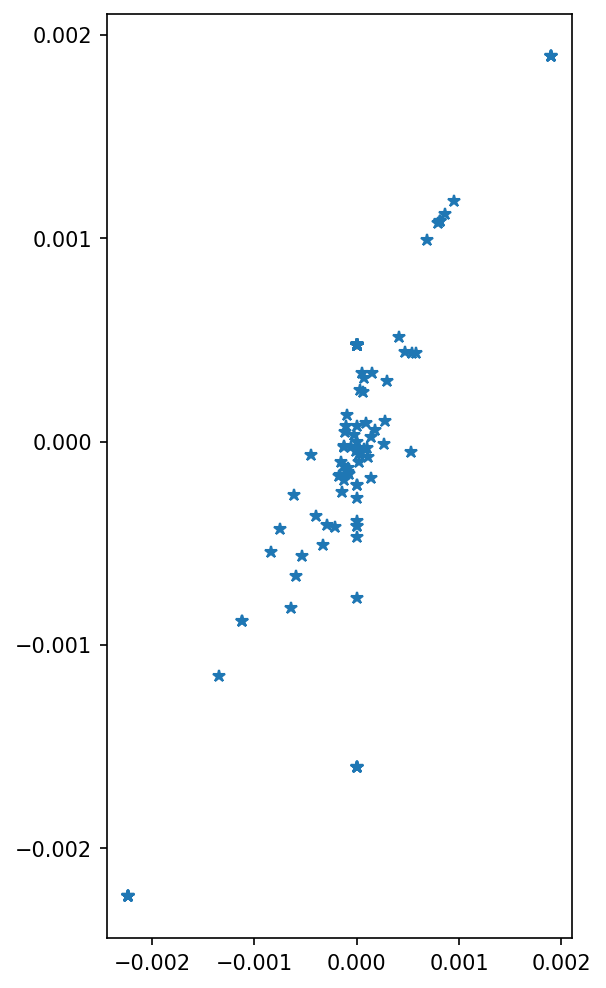

In [30]:
plt.plot(perception["female_lean"],perception["group_lean"], "*")

In [33]:
perception["group_lean"].corr(perception["male_lean"]) 

0.5466172936889899

In [32]:
perception["group_lean"].corr(perception["female_lean"]) 

0.8478340140540099

In [31]:
perception["male_lean"].corr(perception["female_lean"]) 

0.01940882884708375

## TF-IDF Visualization

In [15]:
import matplotlib as mpl

In [16]:
# The DPI is set to 150 for version control and upload to GitHub. 
# For better readability, increase the resolution to 300.
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams["figure.figsize"]=4,8

In [15]:
# Restrict the data we visualize to the top 100 verbs
top = tfidf.head(100)

In [17]:
# Set our data
y = top.index.tolist()
men_he    = [ (-1*i) for i in top.m_he.tolist()]
women_he  = [ (-1*i) for i in top.w_he.tolist()]
men_she   = top.m_she.tolist()
women_she = top.w_she.tolist()

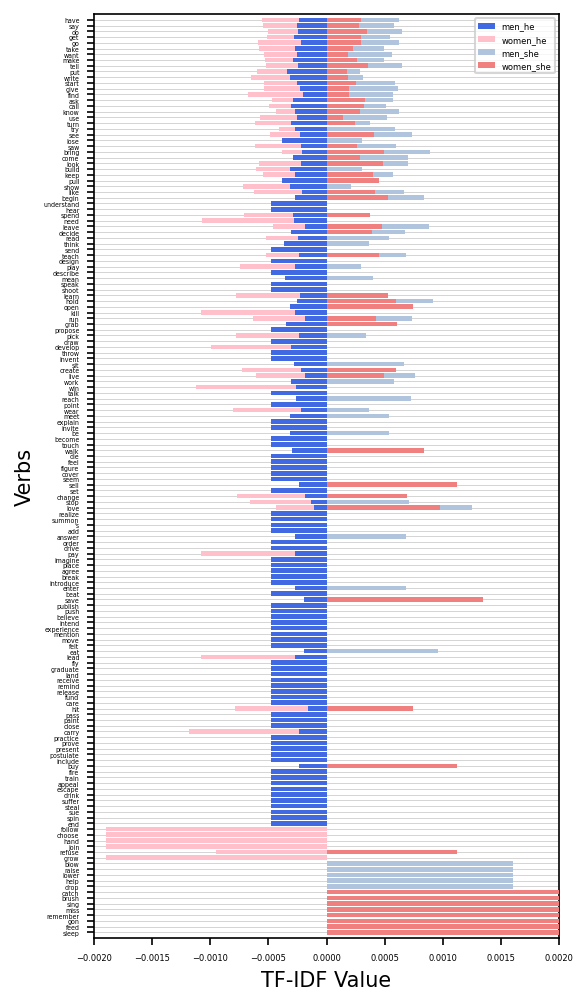

In [18]:
# Put the crazy machinations of MPL into motion
fig, ax = plt.subplots()

ax.set_xlim([-0.002, 0.002])
ax.set_ylim([-1, len(y)])

ax.grid(zorder=0)
ax.yaxis.grid(True, which='major', linewidth = '0.25')
ax.xaxis.grid(False)

ax.set_xlabel('TF-IDF Value')
ax.tick_params(axis='x', labelsize=4)
ax.set_xticks([-0.002, -0.0015, -0.001, -0.0005, 0, 0.0005, 0.001, 0.0015, 0.002])

ax.set_ylabel('Verbs')
ax.set_yticks(range(len(y)))
ax.set_yticklabels(y)
ax.tick_params(axis='y', labelsize=3)

# ax.axvline(x=0, color='gray')

he_bottom = np.cumsum(np.vstack([np.zeros(len(y)), men_he, women_he]), axis=0)
she_bottom = np.cumsum(np.vstack([np.zeros(len(y)), women_she, men_she]), axis=0)

ax.barh(y, men_he, label='men_he', color='royalblue', zorder=3)
ax.barh(y, women_he, label='women_he', left = men_he, color='pink', zorder=3)
ax.barh(y, men_she, label='men_she', left = women_she, color='lightsteelblue', zorder=3)
ax.barh(y, women_she, label='women_she', color='lightcoral', zorder=3)

# for i, val in enumerate(y):
#     ax.text(-0.002, i, val, ha='right', va='center')

ax.legend(fontsize=4) 

plt.gca().invert_yaxis()

plt.show()

### An Attempt to Sort by How Gendered a Verb Is -- `Not Working`

ValueError: shape mismatch: objects cannot be broadcast to a single shape

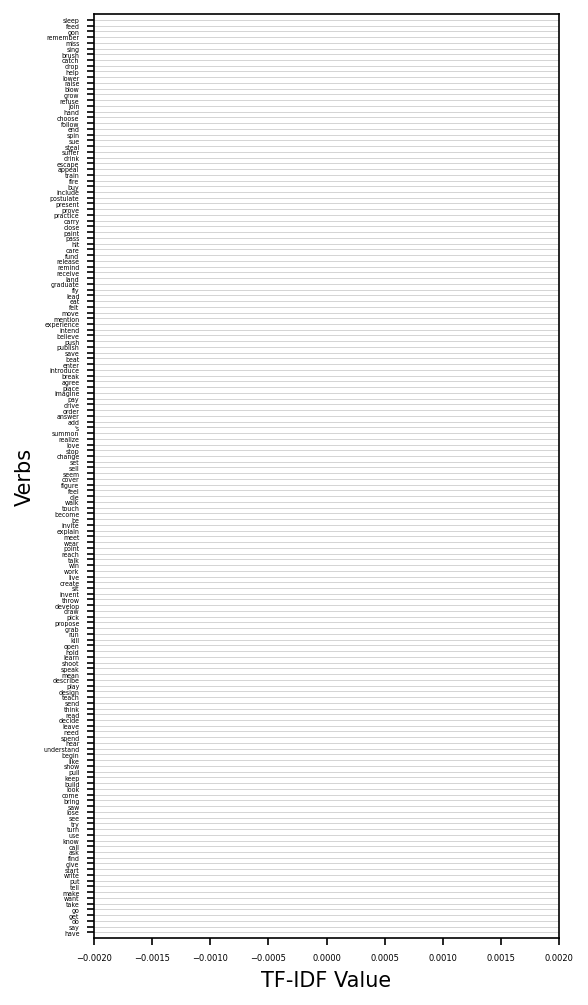

In [19]:
y = tfidf.index.tolist()
men_he    = [ (-1*i) for i in tfidf.m_he.tolist()]
women_he  = [ (-1*i) for i in tfidf.w_he.tolist()]
men_she   = tfidf.m_she.tolist()
women_she = tfidf.w_she.tolist()

# calculate the sum of the values for each bar
he_totals = np.sum(np.vstack([men_he, women_he]), axis=0)
she_totals = np.sum(np.vstack([women_she, men_she]), axis=0)

# sort the bars based on their overall values
he_indices = np.argsort(he_totals)[::-1]
she_indices = np.argsort(she_totals)[::-1]


# reorder the data and labels based on the sorted indices
y_sorted = [y[i] for i in np.concatenate([he_indices, she_indices])]
women_he_sorted = [women_he[i] for i in he_indices]
men_he_sorted = [men_he[i] for i in he_indices]
women_she_sorted = [women_she[i] for i in she_indices]
men_she_sorted = [men_she[i] for i in she_indices]

fig, ax = plt.subplots()

ax.set_xlim([-0.002, 0.002])
ax.set_ylim([-1, len(y)])

ax.grid(zorder=0)
ax.yaxis.grid(True, which='major', linewidth = '0.25')
ax.xaxis.grid(False)

ax.set_xlabel('TF-IDF Value')
ax.tick_params(axis='x', labelsize=4)
ax.set_xticks([-0.002, -0.0015, -0.001, -0.0005, 0, 0.0005, 0.001, 0.0015, 0.002])

ax.set_ylabel('Verbs')
ax.set_yticks(range(len(y)))
ax.set_yticklabels(y)
ax.tick_params(axis='y', labelsize=3)

# ax.axvline(x=0, color='gray')

# he_bottom = np.cumsum(np.vstack([np.zeros(len(y)), men_he, women_he]), axis=0)
# she_bottom = np.cumsum(np.vstack([np.zeros(len(y)), women_she, men_she]), axis=0)

he_bottom = np.zeros(len(y))
she_bottom = np.zeros(len(y))

ax.barh(y_sorted, men_he_sorted, label='men_he', color='royalblue', zorder=3)
ax.barh(y_sorted, women_he_sorted, label='women_he', left = men_he, color='pink', zorder=3)
ax.barh(y_sorted, men_she_sorted, label='men_she', left = women_she, color='lightsteelblue', zorder=3)
ax.barh(y_sorted, women_she_sorted, label='women_she', color='lightcoral', zorder=3)

ax.legend(fontsize=4) 

plt.show()